In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [4]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

228818944/228813984 [==============================] - 85s 0us/step


In [5]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


In [19]:
batch_size = 32
img_height = 100
img_width = 150

In [23]:
data_dir = '/Users/khoa1799/GitHub/mask_detector/preprocessing_data'
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 985 files belonging to 2 classes.
Using 788 files for training.


In [24]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 985 files belonging to 2 classes.
Using 197 files for validation.


In [25]:
class_names = train_ds.class_names
print(class_names)

['mask', 'unmask']


In [26]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [27]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [28]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.15686275 0.9058824


In [29]:
num_classes = 2

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [30]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [31]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_3 (Rescaling)      (None, 100, 150, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 100, 150, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 50, 75, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 50, 75, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 25, 37, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 25, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 12, 18, 64)       

In [32]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
25/25 [==============================] - 4s 141ms/step - loss: 0.7428 - accuracy: 0.7298 - val_loss: 4.2741e-04 - val_accuracy: 1.0000
Epoch 2/10
25/25 [==============================] - 3s 127ms/step - loss: 2.8174e-04 - accuracy: 1.0000 - val_loss: 2.3018e-06 - val_accuracy: 1.0000
Epoch 3/10
25/25 [==============================] - 4s 146ms/step - loss: 2.5003e-06 - accuracy: 1.0000 - val_loss: 9.6638e-07 - val_accuracy: 1.0000
Epoch 4/10
25/25 [==============================] - 4s 148ms/step - loss: 6.7156e-07 - accuracy: 1.0000 - val_loss: 4.3508e-07 - val_accuracy: 1.0000
Epoch 5/10
25/25 [==============================] - 4s 152ms/step - loss: 5.7786e-07 - accuracy: 1.0000 - val_loss: 4.0180e-07 - val_accuracy: 1.0000
Epoch 6/10
25/25 [==============================] - 4s 158ms/step - loss: 3.2144e-07 - accuracy: 1.0000 - val_loss: 3.5036e-07 - val_accuracy: 1.0000
Epoch 7/10
25/25 [==============================] - 4s 153ms/step - loss: 3.0617e-07 - accuracy: 1.0000 

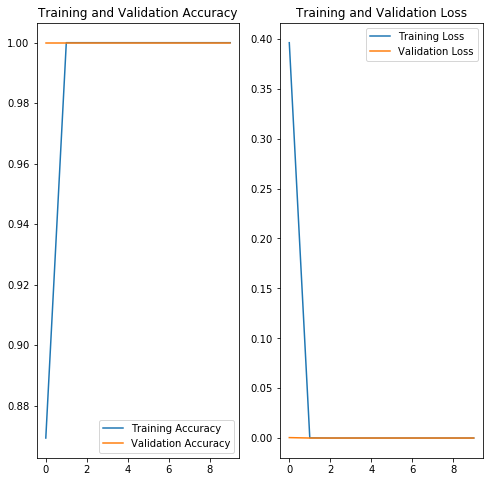

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [34]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

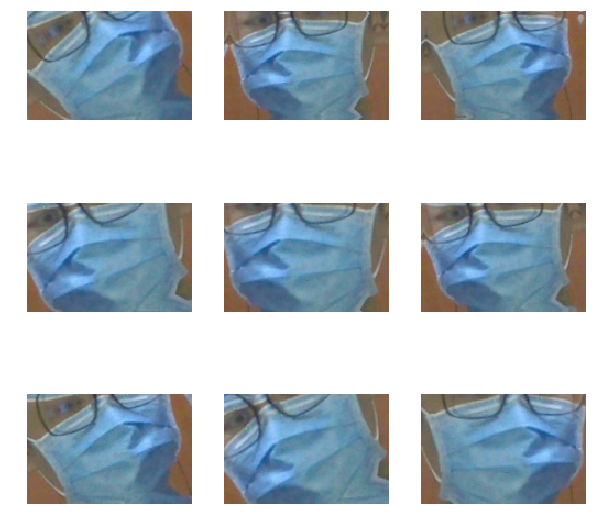

In [35]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [36]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [37]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [38]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_2 (Sequential)    (None, 100, 150, 3)       0         
_________________________________________________________________
rescaling_4 (Rescaling)      (None, 100, 150, 3)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 100, 150, 16)      448       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 50, 75, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 50, 75, 32)        4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 25, 37, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 25, 37, 64)       

In [39]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
25/25 [==============================] - 4s 154ms/step - loss: 0.5601 - accuracy: 0.8045 - val_loss: 8.5959e-04 - val_accuracy: 1.0000
Epoch 2/15
25/25 [==============================] - 4s 164ms/step - loss: 9.5949e-04 - accuracy: 1.0000 - val_loss: 1.9818e-04 - val_accuracy: 1.0000
Epoch 3/15
25/25 [==============================] - 4s 172ms/step - loss: 1.4459e-04 - accuracy: 1.0000 - val_loss: 4.0295e-06 - val_accuracy: 1.0000
Epoch 4/15
25/25 [==============================] - 4s 168ms/step - loss: 5.3937e-06 - accuracy: 1.0000 - val_loss: 1.9213e-06 - val_accuracy: 1.0000
Epoch 5/15
25/25 [==============================] - 4s 167ms/step - loss: 2.7989e-06 - accuracy: 1.0000 - val_loss: 1.4474e-06 - val_accuracy: 1.0000
Epoch 6/15
25/25 [==============================] - 4s 168ms/step - loss: 2.2384e-06 - accuracy: 1.0000 - val_loss: 1.1261e-06 - val_accuracy: 1.0000
Epoch 7/15
25/25 [==============================] - 4s 168ms/step - loss: 1.5795e-06 - accuracy: 1.0000 

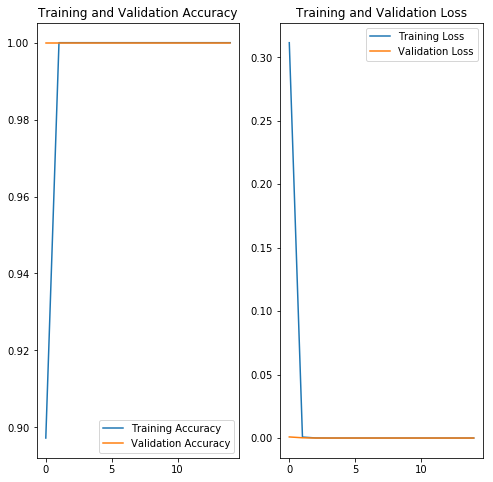

In [40]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [41]:
sunflower_path = '/Users/khoa1799/GitHub/mask_detector/mask_data/extracted_image/unmaksed/0.jpg'

img = keras.preprocessing.image.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to unmask with a 100.00 percent confidence.


In [42]:
filepath = '/Users/khoa1799/GitHub/mask_detector/mask_data/tf_mask_detector_model'
tf.keras.models.save_model(
    model, filepath, overwrite=True, include_optimizer=True, save_format=None,
    signatures=None, options=None, save_traces=True
)

INFO:tensorflow:Assets written to: /Users/khoa1799/GitHub/mask_detector/mask_data/tf_mask_detector_model/assets


In [47]:
import cv2

new_model = tf.keras.models.load_model('/Users/khoa1799/GitHub/mask_detector/mask_data/tf_mask_detector_model')

img = cv2.imread(sunflower_path)
img = cv2.resize(img,(100, 150))

img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to mask with a 100.00 percent confidence.
